# Общее

Данная модель обучалась на данных, взятых из датасета, который используется для соревнования на kaggle.

# Подготовка к работе

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline

В качестве датасета будут использоваться данные с соревнования kaggle, поэтому необходимо загрузить файл с oauth_token.

In [10]:
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [11]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Подготовка данных

In [14]:
train = np.genfromtxt('train.csv', delimiter = ',')
test1 = np.genfromtxt('test.csv', delimiter = ',')

In [15]:
y_train = train[1:,0].reshape(42000, 1)
x_train = train[1:,1:].reshape(42000, 28, 28, 1)
x_test1 = test1[1:,0:].reshape(28000, 28, 28, 1)

Посмотрим на данные из датасета

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


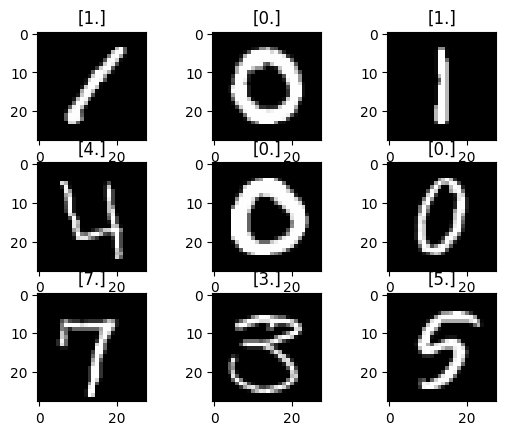

In [16]:
for i in range(9):
    plt.subplot(3, 3, (i + 1))
    plt.imshow(x_train[i][:,:,0], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

Подготовим данные для обучения

In [17]:
x_train, x_test1 = x_train / 255., x_test1 / 255.
y_train = utils.to_categorical(y_train, 10)

Разделим на сет для обучения и тестовый

In [18]:
val_test = int(x_train.shape[0] * 0.15)
x_test = x_train[:val_test]
x_train = x_train[val_test:]
y_test = y_train[:val_test]
y_train = y_train[val_test:]

Сохраним лучшую модель в model.h5

In [19]:
model_path = 'model.h5'
callback = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

Модель будет состоять в основном из слоев двумерной свертки

Также на выходе будет полносвязный слой с 10 нейронами, чтобы классифицировать цифры

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Сохраним вывод для дальнейшей визуализации данных

In [22]:
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=200,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8479
Epoch 1: val_accuracy improved from -inf to 0.96877, saving model to model.h5
143/143 [==============================] - 15s 18ms/step - loss: 0.4818 - accuracy: 0.8479 - val_loss: 0.1011 - val_accuracy: 0.9688
Epoch 2/50
 13/143 [=>............................] - ETA: 1s - loss: 0.1068 - accuracy: 0.9665

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/143 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9699
Epoch 2: val_accuracy improved from 0.96877 to 0.97857, saving model to model.h5
143/143 [==============================] - 2s 11ms/step - loss: 0.0986 - accuracy: 0.9701 - val_loss: 0.0636 - val_accuracy: 0.9786
Epoch 3/50
141/143 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9815
Epoch 3: val_accuracy improved from 0.97857 to 0.98459, saving model to model.h5
143/143 [==============================] - 2s 11ms/step - loss: 0.0632 - accuracy: 0.9816 - val_loss: 0.0544 - val_accuracy: 0.9846
Epoch 4/50
139/143 [============================>.] - ETA: 0s - loss: 0.0474 - accuracy: 0.9851
Epoch 4: val_accuracy improved from 0.98459 to 0.98641, saving model to model.h5
143/143 [==============================] - 2s 11ms/step - loss: 0.0486 - accuracy: 0.9847 - val_loss: 0.0510 - val_accuracy: 0.9864
Epoch 5/50
142/143 [============================>.] - ETA: 0s - loss: 0.0359 - accur

In [23]:
model.evaluate(x_test, y_test, verbose=1)

197/197 [==============================] - 1s 5ms/step - loss: 0.0505 - accuracy: 0.9884


[0.0505409762263298, 0.9884126782417297]

Как видно, на тестовых данных точность ~98%

# Визуализация данных

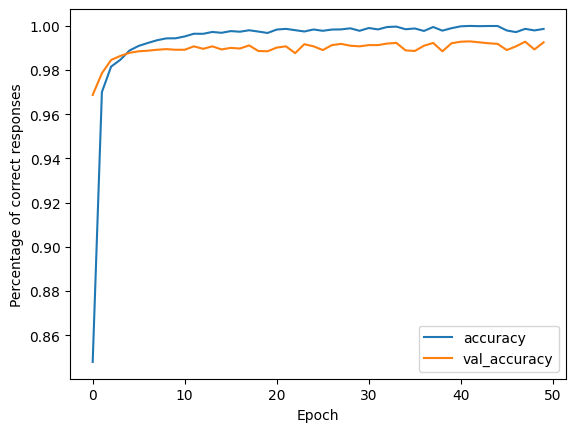

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Percentage of correct responses')
plt.legend()
plt.show()

Видим, что тестирование на проверочной выборке показывает результаты хуже, чем на тренировочной

Попробуем предсказать значения тестового датасета

In [29]:
y_pred = model.predict(x_test1)
result=np.argmax(y_pred,axis=1)
submissions=pd.DataFrame({"ImageId": list(range(1,len(result)+1)), "Label": result})
submissions.to_csv("predictions_mnist.csv", index=False, header=True)

875/875 [==============================] - 2s 2ms/step


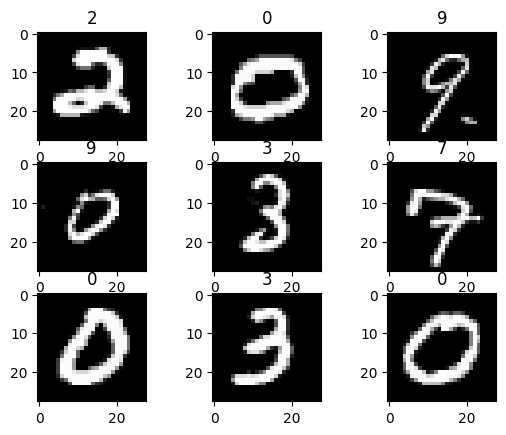

In [31]:
for i in range(9):
    plt.subplot(3, 3, (i + 1))
    plt.imshow(x_test1[i][:,:,0], cmap=plt.get_cmap('gray'))
    plt.title(result[i])

Из 9-ти результатов модель дает довольно точные результаты, но не все, и модель можно улучшить
